In [1]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pickle

In [6]:
downloads_dir = "./data/downloads"
dataset_dir = "./data/dataset"
train_dir = dataset_dir + "/Data/Train"
valid_dir = dataset_dir + "/Data/Validation"
test_dir = dataset_dir + "/Data/Test"

In [ ]:
os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
!wget "https://dl.dropboxusercontent.com/scl/fi/tpw3152el19dyblp6wke7/DataB1toB6.zip?rlkey=2lydbphdogrc5rg71rg1ynyut&st=cfyp3bge&dl=0" -O {downloads_dir}/DataB1toB6.zip
!wget "https://dl.dropboxusercontent.com/scl/fi/3veksk2or8vcpc9hsvkc4/DataB7toB13.zip?rlkey=yly29pqdh086zxgo2a2npgwj9&st=jh3ti1bm&dl=0" -O {downloads_dir}/DataB7toB13.zip
!wget "https://dl.dropboxusercontent.com/scl/fi/11tgme77ylkbs335e5w7j/DataKendall.zip?rlkey=5gr5itpj0q4ryn6t650ow26ce&st=nxluahih&dl=0" -O {downloads_dir}/DataKendall.zip
!wget "https://dl.dropboxusercontent.com/scl/fi/ofko1ni6yhz3d0hlkc4m8/DataStata.zip?rlkey=kzgduzecfl0uml6y1snqdeuap&st=54swm200&dl=0" -O {downloads_dir}/DataStata.zip

#dataset of all of main campus' tunnels

--2024-05-14 14:19:46--  https://dl.dropboxusercontent.com/scl/fi/tpw3152el19dyblp6wke7/DataB1toB6.zip?rlkey=2lydbphdogrc5rg71rg1ynyut&st=cfyp3bge&dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:6020:15::a27d:400f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.2.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 906480185 (864M) [application/zip]
Saving to: ‘./data/downloads/DataB1toB6.zip’

./data/downloads/Da 100%[===================>] 864.49M  89.4MB/s    in 10s     

2024-05-14 14:19:57 (86.1 MB/s) - ‘./data/downloads/DataB1toB6.zip’ saved [906480185/906480185]

--2024-05-14 14:19:57--  https://dl.dropboxusercontent.com/scl/fi/3veksk2or8vcpc9hsvkc4/DataB7toB13.zip?rlkey=yly29pqdh086zxgo2a2npgwj9&st=jh3ti1bm&dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:6020:15::a27d:400f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.

In [ ]:
!unzip {downloads_dir}/DataB1toB6.zip -d {downloads_dir}
!unzip {downloads_dir}/DataB7toB13.zip -d {downloads_dir}
!unzip {downloads_dir}/DataKendall.zip -d {downloads_dir}
!unzip {downloads_dir}/DataStata.zip -d {downloads_dir}

Streaming output truncated to the last 5000 lines.
  inflating: ./data/downloads/DataStata/Train/B32L3_North/329.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/305.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/107.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/113.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/265.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/259.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/258.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/264.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/270.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/13.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/106.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/338.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/310.png  
  inflating: ./data/downloads/DataStata/Train/B32L3_North/306.png 

In [ ]:
#testing
os.system(f"mv {downloads_dir}/DataB1toB6/Train/* {train_dir}")
os.system(f"mv {downloads_dir}/DataB1toB6/Validation/* {valid_dir}")
os.system(f"mv {downloads_dir}/DataB1toB6/Test/* {test_dir}")

os.system(f"mv {downloads_dir}/DataB7toB13/Train/* {train_dir}")
os.system(f"mv {downloads_dir}/DataB7toB13/Validation/* {valid_dir}")
os.system(f"mv {downloads_dir}/DataB7toB13/Test/* {test_dir}")

os.system(f"mv {downloads_dir}/DataKendall/Train/* {train_dir}")
os.system(f"mv {downloads_dir}/DataKendall/Validation/* {valid_dir}")
os.system(f"mv {downloads_dir}/DataKendall/Test/* {test_dir}")

os.system(f"mv {downloads_dir}/DataStata/Train/* {train_dir}")
os.system(f"mv {downloads_dir}/DataStata/Validation/* {valid_dir}")
os.system(f"mv {downloads_dir}/DataStata/Test/* {test_dir}")

0

In [2]:
class ResNetClassifier(nn.Module):
    """
    Define ResNet model class
    """
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet34(pretrained=True) #uses a pretrained resnet34 model from torchvision. testing 18
        #self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes) #change the classification fc layer to have the correct number of classes
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5), #dropout layer to prevent overfitting. only of the fc layer tho, see if it does anything
            nn.Linear(self.resnet.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [3]:
# Define a custom dataset for video frames
class VideoFrameDataset(Dataset):
    def __init__(self, frames, labels, transform=None):
        self.frames = frames  # list of frames as np arrays
        self.labels = labels  # corresponding labels for each frame
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        label = self.labels[idx]

        if isinstance(frame, np.ndarray):
            frame = Image.fromarray(frame)
        if self.transform:
            frame = self.transform(frame)

        #reverts frames to ndarray. ensures frames and labels are tensors so we can use .to(device)
        frame = torch.tensor(np.array(frame)).clone().detach().float()
        label = torch.tensor(label, dtype=torch.long)
        return frame, label

In [4]:
def load_data(directory):
    frames = []  # list of frames
    labels = []  # corresponding labels
    with os.scandir(directory) as folder_iterator:
        for folder in folder_iterator:
            if not folder.is_dir():
                continue
            label = folder.name
            with os.scandir(folder.path) as frame_iterator:
                for frame in frame_iterator:
                    if not frame.is_file() or not frame.name.lower().endswith('png'):
                        #if file is not png do not yield it
                        continue
                    image_path = os.path.join(folder.path, frame.name)
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  #by default cv2 reads in bgr
                    frames.append(image)  #appends an array
                    labels.append(label)

    # numerically convert labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    return frames, labels, label_encoder

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),   # randomly rotate the image by up to 10 degrees
    transforms.RandomResizedCrop(size= 224,   # final output image size
                                scale=(0.8, 1.0),   # selects a random scale of the original image, and crops image randomly to meet this scale
                                ratio=(1,1)),# resize the image to 540x960 while maintaining aspect ratio
    transforms.ToTensor()
])

train_frames, train_labels, label_encoder = load_data(train_dir)
valid_frames, valid_labels, _ = load_data(valid_dir)
test_frames, test_labels, _ = load_data(test_dir)

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

train_dataset = VideoFrameDataset(train_frames, train_labels, transform=train_transforms)
#train_dataset = VideoFrameDataset(train_frames, train_labels, transform=transform)
train_dataload = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0) #workers to 0 for now because of multiprocessing issues

valid_dataset = VideoFrameDataset(valid_frames, valid_labels, transform=transform)
valid_dataload = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)

test_dataset = VideoFrameDataset(test_frames, test_labels, transform=transform)
test_dataload = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

num_classes = len(np.unique(train_labels))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetClassifier(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#figure out what inputs and labels looks like
for inputs,labels in train_dataload:
  print(inputs)
  print(labels)
  print(inputs.size())
  break

tensor([[[[0.4431, 0.4431, 0.4431,  ..., 0.6627, 0.6588, 0.6588],
          [0.4471, 0.4471, 0.4471,  ..., 0.6627, 0.6588, 0.6588],
          [0.4510, 0.4510, 0.4510,  ..., 0.6627, 0.6588, 0.6588],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3647, 0.3647, 0.3608],
          [0.0000, 0.0000, 0.0000,  ..., 0.3686, 0.3647, 0.3647],
          [0.0000, 0.0000, 0.0000,  ..., 0.3608, 0.3569, 0.3569]],

         [[0.3529, 0.3529, 0.3529,  ..., 0.5843, 0.5804, 0.5804],
          [0.3569, 0.3569, 0.3569,  ..., 0.5843, 0.5804, 0.5804],
          [0.3608, 0.3608, 0.3608,  ..., 0.5843, 0.5804, 0.5804],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3059, 0.3059, 0.3020],
          [0.0000, 0.0000, 0.0000,  ..., 0.3098, 0.3059, 0.3059],
          [0.0000, 0.0000, 0.0000,  ..., 0.3020, 0.2980, 0.2980]],

         [[0.2941, 0.2941, 0.2941,  ..., 0.5569, 0.5529, 0.5529],
          [0.2980, 0.2980, 0.2980,  ..., 0.5569, 0.5529, 0.5529],
          [0.3020, 0.3020, 0.3020,  ..., 0

In [ ]:
for inputs,labels in valid_dataload:
  print(inputs)
  print(labels)
  print(inputs.size())
  break

tensor([[[[0.7725, 0.5216, 0.3686,  ..., 0.5686, 0.5686, 0.5725],
          [0.8039, 0.4941, 0.3608,  ..., 0.5686, 0.5686, 0.5686],
          [0.7725, 0.5529, 0.3490,  ..., 0.5686, 0.5647, 0.5647],
          ...,
          [0.7098, 0.7412, 0.5922,  ..., 0.5176, 0.5569, 0.6980],
          [0.7216, 0.7333, 0.5961,  ..., 0.6078, 0.5216, 0.6353],
          [0.7137, 0.7059, 0.6667,  ..., 0.7294, 0.5922, 0.5294]],

         [[0.8275, 0.5882, 0.3529,  ..., 0.5451, 0.5451, 0.5490],
          [0.8353, 0.5059, 0.3451,  ..., 0.5451, 0.5451, 0.5451],
          [0.8471, 0.5412, 0.3333,  ..., 0.5451, 0.5412, 0.5412],
          ...,
          [0.7804, 0.7451, 0.5765,  ..., 0.5020, 0.5333, 0.6745],
          [0.7843, 0.7490, 0.5804,  ..., 0.5922, 0.5059, 0.6157],
          [0.7490, 0.7333, 0.6510,  ..., 0.7137, 0.5765, 0.5098]],

         [[0.8078, 0.5608, 0.3216,  ..., 0.4980, 0.4980, 0.5020],
          [0.8118, 0.4784, 0.3137,  ..., 0.4980, 0.4980, 0.4980],
          [0.8275, 0.5176, 0.3059,  ..., 0

In [8]:
def evaluate_model(model, dataloader, criterion):
    """
    Evaluates a trained model given a validation/test dataloader

    Input:
    model: the model we would like to train
    dataloader: the data
    criterion: the loss function used to determine loss
    optimizer: the optimizer used in backpropagation
    num_epochs: the number of epochs we train for


    Output:
    the loss and accuracy
    """
    model.eval()

    running_loss = 0.0
    accurate_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            accurate_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss/total_pred
    accuracy = accurate_pred/total_pred

    return avg_loss, accuracy

In [9]:
def train_model(model, train_dataload, valid_dataload, criterion, optimizer, num_epochs=25, patience = 5):
    """
    Trains a given model over a given number of epochs. Default set to 25.

    Input:
    model: the model we would like to train
    dataloader: the data
    criterion: the loss function used to determine loss
    optimizer: the optimizer used in backpropagation
    num_epochs: the number of epochs we train for


    Output:
    a trained model
    """
    best_val_loss = float('inf')

    stored_accloss = []

    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    used_patience = 0

    early_stop = False


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dataload:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataload.dataset)

        valid_loss, valid_acc = evaluate_model(model, valid_dataload, criterion)

        stored_accloss.append((epoch_loss, valid_loss, valid_acc))


        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save(model.state_dict(), f"best_model.pth")
            torch.save(model, f"full_best_model.pth")
            used_patience = 0
            print('Saved new model')
        else:
            used_patience += 1
            if used_patience >= patience:
                print('Stopping early')
                early_stop = True
                break


        print(f'Epoch {epoch}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy {valid_acc:.4f}')

        scheduler.step()


    #plot the acc and losses
    plt.plot([x[0] for x in stored_accloss], label='Train Loss')
    plt.plot([x[1] for x in stored_accloss], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.plot([x[2] for x in stored_accloss], label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    plt.show()

    return model


Saved new model
Epoch 0/25, Train Loss: 4.3616, Valid Loss: 3.2297, Valid Accuracy 0.5301
Saved new model
Epoch 1/25, Train Loss: 2.8376, Valid Loss: 1.8405, Valid Accuracy 0.8191
Saved new model
Epoch 2/25, Train Loss: 1.7933, Valid Loss: 1.0599, Valid Accuracy 0.9054
Saved new model
Epoch 3/25, Train Loss: 1.1744, Valid Loss: 0.6311, Valid Accuracy 0.9455
Saved new model
Epoch 4/25, Train Loss: 0.8112, Valid Loss: 0.4109, Valid Accuracy 0.9673
Saved new model
Epoch 5/25, Train Loss: 0.5978, Valid Loss: 0.2737, Valid Accuracy 0.9761
Saved new model
Epoch 6/25, Train Loss: 0.4489, Valid Loss: 0.1927, Valid Accuracy 0.9840
Saved new model
Epoch 7/25, Train Loss: 0.3486, Valid Loss: 0.1439, Valid Accuracy 0.9895
Saved new model
Epoch 8/25, Train Loss: 0.2756, Valid Loss: 0.1085, Valid Accuracy 0.9924
Saved new model
Epoch 9/25, Train Loss: 0.2256, Valid Loss: 0.0784, Valid Accuracy 0.9949
Saved new model
Epoch 10/25, Train Loss: 0.2001, Valid Loss: 0.0753, Valid Accuracy 0.9948
Epoch 11/

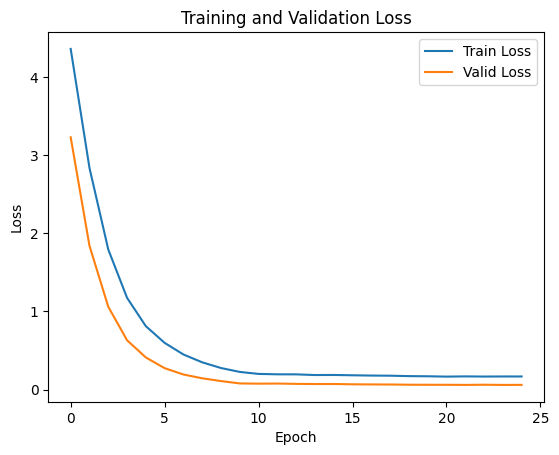

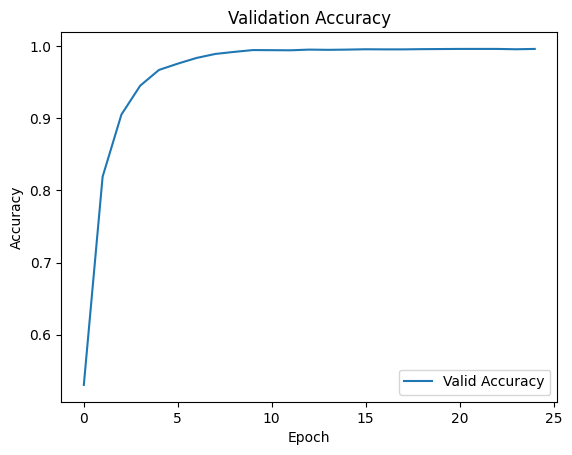

In [ ]:
trained_model = train_model(model, train_dataload, valid_dataload, criterion, optimizer, num_epochs=25)

In [ ]:
#evaluate with test set
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_accuracy = evaluate_model(model, test_dataload, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy {test_accuracy:.4f}')

Test Loss: 0.0585, Test Accuracy 0.9966


# **Below is the download of our best model, as well as code to test its accuracy**

In [19]:
#download the best model:
!wget "https://dl.dropboxusercontent.com/scl/fi/dvxv0xa26l41504zacabr/full_best_model7.pth?rlkey=qyelo2j17i0wl2uwfd15slfg6&st=ujyeo8xp&dl=0" -O full_best_model7.pth
!wget "https://www.dl.dropboxusercontent.com/scl/fi/062njcxw41qx08up0bv3h/best_model7.pth?rlkey=6qftx5gz4eivef0shypq850id&st=8b36elgg&dl=0" -O best_model7.pth

--2024-05-14 15:17:40--  https://dl.dropboxusercontent.com/scl/fi/dvxv0xa26l41504zacabr/full_best_model7.pth?rlkey=qyelo2j17i0wl2uwfd15slfg6&st=ujyeo8xp&dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:6017:15::a27d:20f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.2.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85543598 (82M) [application/octet-stream]
Saving to: ‘full_best_model7.pth’

full_best_model7.pt 100%[===================>]  81.58M  63.7MB/s    in 1.3s    

2024-05-14 15:17:44 (63.7 MB/s) - ‘full_best_model7.pth’ saved [85543598/85543598]

--2024-05-14 15:17:44--  https://www.dl.dropboxusercontent.com/scl/fi/062njcxw41qx08up0bv3h/best_model7.pth?rlkey=6qftx5gz4eivef0shypq850id&st=8b36elgg&dl=0
Resolving www.dl.dropboxusercontent.com (www.dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:6020:15::a27d:400f
Connecting to www.dl.dropboxusercontent.com (www.dl.dropboxuser

In [20]:
#evaluate downloaded model's accuracy and loss
model.load_state_dict(torch.load('best_model7.pth'))
test_loss, test_accuracy = evaluate_model(model, test_dataload, criterion)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy {test_accuracy:.4f}')

Test Loss: 0.0585, Test Accuracy 0.9966


In [17]:
#evaluate downloaded model with test set by comparing classes
final_model = torch.load('full_best_model7.pth')
final_model.eval()

ResNetClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
for inputs, real_labels in test_dataload:
    inputs, real_labels = inputs.to(device), real_labels.to(device)
    outputs = final_model(inputs)
    _, prediction = torch.max(outputs, 1)
    print('real:', real_labels, '\n', 'pred:',prediction, '\n')

real: tensor([51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51],
       device='cuda:0') 
 pred: tensor([51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51],
       device='cuda:0') 

real: tensor([51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 51, 51, 51, 51, 71, 71, 71, 71, 71, 71, 71],
       device='cuda:0') 
 pred: tensor([51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 51, 51, 51, 51, 71, 71, 71, 71, 71, 71, 71],
       device='cuda:0') 

real: tensor([71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71,
        71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71],
       device='cuda:0') 
 pred: tensor([71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71,
        71, 71, 71, 71, 71, 7

In [18]:
with open('label_encoder.pkl', 'rb') as file:
    loaded_label_encoder = pickle.load(file)

for inputs, labels in test_dataload:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = final_model(inputs)
    _, prediction = torch.max(outputs, 1)

    prediction_labels_numpy = prediction.cpu().numpy()
    real_labels_numpy = labels.cpu().numpy()


    prediction_labels = loaded_label_encoder.inverse_transform(prediction_labels_numpy)
    real_labels = loaded_label_encoder.inverse_transform(real_labels_numpy)
    print('real:', real_labels, '\n', 'pred:',prediction_labels, '\n')



real: ['B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South'] 
 pred: ['B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South'] 

real: ['B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South'
 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South' 'B4H1_South